In [1]:
from utils import lab_utils
from utils import transforms2 as extended_transforms
from utils import joint_transforms as joint_transforms

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import json, string
from torch.utils import data
import numpy as np
import os

%matplotlib inline

In [2]:
# Define the data loader.
n_classes = 19
ignore_label = 255
root = 'dataset'

def obtain_dir(mode, root):
    # "mode" can be "train", "test", or "val".
    mask_path = os.path.join(root, 'gtFine', mode)
    img_path = os.path.join(root, 'leftImg8bit', mode)
    # The only difference between mask and image names are postfix.
    mask_postfix = '_gtFine_labelIds.png'
    # Get paths for all of 8-bit images and corresponding masks.
    items = []
    categories = os.listdir(img_path)
    for c in categories:
        c_items = [name.split('_leftImg8bit.png')[0] for name in os.listdir(os.path.join(img_path, c))]
        for it in c_items:
            item = (os.path.join(img_path, c, it + '_leftImg8bit.png'), os.path.join(mask_path, c, it + mask_postfix))
            items.append(item)
    # Return a set of tuples.
    return items


class CityScapes(data.Dataset):
    def __init__(self, mode, root, transform=None, target_transform=None,joint_transform=None):
        self.imgs = obtain_dir(mode, root)
        self.joint_transform = joint_transform
        self.transform = transform
        self.target_transform = target_transform
        # Only care about 19 classes. See the dataset paper for details.
        self.id_to_trainid = {-1: ignore_label, 0: ignore_label, 1: ignore_label, 2: ignore_label,
                              3: ignore_label, 4: ignore_label, 5: ignore_label, 6: ignore_label,
                              7: 0, 8: 1, 9: ignore_label, 10: ignore_label, 11: 2, 12: 3, 13: 4,
                              14: ignore_label, 15: ignore_label, 16: ignore_label, 17: 5,
                              18: ignore_label, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14,
                              28: 15, 29: ignore_label, 30: ignore_label, 31: 16, 32: 17, 33: 18}

    def __getitem__(self, index):
        img_path, mask_path = self.imgs[index]
        img, mask = Image.open(img_path).convert('RGB'), Image.open(mask_path)

        mask = np.array(mask)
        mask_copy = mask.copy()
        for k, v in self.id_to_trainid.items():
            mask_copy[mask == k] = v
        mask = Image.fromarray(mask_copy.astype(np.uint8))
        
        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            mask = self.target_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [3]:
# In order to show segmentations in different colors.
palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]
zero_pad = 256 * 3 - len(palette)
for i in range(zero_pad):
    palette.append(0)

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
    return new_mask

In [4]:
# This is a mofified Resnet with deconvolutional layers added.
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)


class SegNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(SegNet, self).__init__()
        vgg = models.vgg19_bn()
        if pretrained:
            vgg.load_state_dict(torch.load("vgg19_bn_c79401a0.pth"))
        features = list(vgg.features.children())
        self.enc1 = nn.Sequential(*features[0:7])
        self.enc2 = nn.Sequential(*features[7:14])
        self.enc3 = nn.Sequential(*features[14:27])
        self.enc4 = nn.Sequential(*features[27:40])
        self.enc5 = nn.Sequential(*features[40:])

        self.dec5 = nn.Sequential(
            *([nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)] +
              [nn.Conv2d(512, 512, kernel_size=3, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(inplace=True)] * 4)
        )
        self.dec4 = _DecoderBlock(1024, 256, 4)
        self.dec3 = _DecoderBlock(512, 128, 4)
        self.dec2 = _DecoderBlock(256, 64, 2)
        self.dec1 = _DecoderBlock(128, num_classes, 2)
        initialize_weights(self.dec5, self.dec4, self.dec3, self.dec2, self.dec1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        dec5 = self.dec5(enc5)
        dec4 = self.dec4(torch.cat([enc4, dec5], 1))
        dec3 = self.dec3(torch.cat([enc3, dec4], 1))
        dec2 = self.dec2(torch.cat([enc2, dec3], 1))
        dec1 = self.dec1(torch.cat([enc1, dec2], 1))
        return dec1

In [5]:
## FCN-8S

class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size,  stride, padding, bias=True):
        super(conv2DBatchNormRelu, self).__init__()

        self.cbr_unit = nn.Sequential(nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size,
                                                padding=padding, stride=stride, bias=bias),
                                 nn.BatchNorm2d(int(n_filters)),
                                 nn.ReLU(inplace=True),)

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs

class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs

class segnet2(nn.Module):

    def __init__(self, n_classes=19, in_channels=3, is_unpooling=True):
        super(segnet2, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)

        return up1


    def init_vgg16_params(self, vgg16):
        blocks = [self.down1,
                  self.down2,
                  self.down3,
                  self.down4,
                  self.down5]

        ranges = [[0, 4], [5, 9], [10, 16], [17, 23], [24, 29]]
        features = list(vgg16.features.children())

        vgg_layers = []
        for _layer in features:
            if isinstance(_layer, nn.Conv2d):
                vgg_layers.append(_layer)

        merged_layers = []
        for idx, conv_block in enumerate(blocks):
            if idx < 2:
                units = [conv_block.conv1.cbr_unit,
                         conv_block.conv2.cbr_unit]
            else:
                units = [conv_block.conv1.cbr_unit,
                         conv_block.conv2.cbr_unit,
                         conv_block.conv3.cbr_unit]
            for _unit in units:
                for _layer in _unit:
                    if isinstance(_layer, nn.Conv2d):
                        merged_layers.append(_layer)

        assert len(vgg_layers) == len(merged_layers)

        for l1, l2 in zip(vgg_layers, merged_layers):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data

In [15]:
import gc
from tqdm import tqdm_notebook as tqdm

class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True, ignore_index=255):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss2d(weight, size_average, ignore_index)
    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets.long())

class CrossEntropy2d(nn.Module):

    def __init__(self, size_average=True, ignore_label=255):
        super(CrossEntropy2d, self).__init__()
        self.size_average = size_average
        self.ignore_label = ignore_label

    def forward(self, predict, target, weight=None):
        """
            Args:
                predict:(n, c, h, w)
                target:(n, h, w)
                weight (Tensor, optional): a manual rescaling weight given to each class.
                                           If given, has to be a Tensor of size "nclasses"
        """
        target = target.long()
        n, c, h, w = predict.size()
        target_mask = (target >= 0) * (target != self.ignore_label)
        target = target[target_mask]
        predict = predict.transpose(1, 2).transpose(2, 3).contiguous()
        predict = predict[target_mask.view(n, h, w, 1).repeat(1, 1, 1, c)].view(-1, c)
        loss = F.cross_entropy(predict, target, weight=weight, size_average=self.size_average)
        return loss    

# These are used to record loss and accuracy data for further plots.
loss_train = np.zeros(10)
loss_validate = np.zeros(10)

# Define the training function.
def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        #network = torch.nn.DataParallel(network, device_ids=[0, 1])
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        
        cum_loss = 0.0
        gc.collect()

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            
            gc.collect()

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = labels.view(labels.size(0),labels.size(2), labels.size(3)) # To satisfy "CrossEntropyLoss2d"
            labels = Variable(labels)
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            t.set_postfix(loss = cum_loss/(i+1))
        
        # Record data for plotting figures.
        loss_train[epoch] = cum_loss/(i+1)
        
        # Make a pass over the validation data.
        cum_loss = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            gc.collect()
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs,volatile=True)
            labels = labels.view(labels.size(0),labels.size(2), labels.size(3)) # To satisfy "CrossEntropyLoss2d"
            labels = Variable(labels,volatile=True)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            t.set_postfix(loss = cum_loss/(i+1))
            
        # Record data for plotting figures.
        loss_validate[epoch] = cum_loss/(i+1)

In [7]:
# Load the fine-annotated Cityscapes dataset.
mean_std = ([103.939, 116.779, 123.68], [1.0, 1.0, 1.0])

imgTransform = transforms.Compose([extended_transforms.FlipChannels(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*mean_std),
                                   transforms.Lambda(lambda x: x.mul_(255))])
#transforms.Scale((64,32)),

target_transform = transforms.Compose([transforms.ToTensor()])
#transforms.Scale((64,32),Image.NEAREST),

args = {
    'train_batch_size': 12,
    'epoch_num': 500,
    'lr': 1e-10,
    'weight_decay': 5e-4,
    'input_size': (32, 64),
    'momentum': 0.99,
    'lr_patience': 100,  # large patience denotes fixed lr
    'snapshot': '',  # empty string denotes no snapshot
    'print_freq': 20,
    'val_batch_size': 16,
    'val_save_to_img_file': False,
    'val_img_sample_rate': 0.05  # randomly sample some validation results to display
}

short_size = int(min(args['input_size']) / 0.875)

train_joint_transform = joint_transforms.Compose([
        joint_transforms.Scale(short_size),
        joint_transforms.RandomCrop(args['input_size']),
        joint_transforms.RandomHorizontallyFlip()
])

val_joint_transform = joint_transforms.Compose([
        joint_transforms.Scale(short_size),
        joint_transforms.CenterCrop(args['input_size'])
])


trainset = CityScapes(mode = 'train', root = 'dataset',transform = imgTransform,
                      target_transform = target_transform,joint_transform=train_joint_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 10, shuffle = True, num_workers = 0)

valset = CityScapes(mode = 'val', root = 'dataset', transform = imgTransform,
                    target_transform = target_transform,joint_transform=val_joint_transform)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 10, shuffle = False, num_workers = 0)

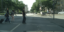

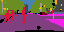

In [8]:
# This is for test only.
un_normalize = lab_utils.UnNormalize((0.4914, 0.4822, 0.4465), 
                                     (0.2023, 0.1994, 0.2010))

restore_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.div_(255)),
        extended_transforms.DeNormalize(*mean_std),
        transforms.ToPILImage(),
        extended_transforms.FlipChannels()
])

img, mask = valset[1]
lab_utils.show_image(restore_transform(img));
lab_utils.show_image(colorize_mask(np.array(lab_utils.tensor2pil(mask))));

HBox(children=(IntProgress(value=0, description='Training epoch 0', max=298), HTML(value='')))

297/|/100%|| 297/298 [08:12<00:01,  1.66s/it, loss=4.77e+04]

HBox(children=(IntProgress(value=0, description='Validation epoch 0', max=50), HTML(value='')))

49/|/ 98%|| 49/50 [01:07<00:01,  1.37s/it, loss=3.92e+04]

HBox(children=(IntProgress(value=0, description='Training epoch 1', max=298), HTML(value='')))

297/|/100%|| 297/298 [08:06<00:01,  1.64s/it, loss=3e+04]04]

HBox(children=(IntProgress(value=0, description='Validation epoch 1', max=50), HTML(value='')))

49/|/ 98%|| 49/50 [01:07<00:01,  1.37s/it, loss=3.8e+04]]

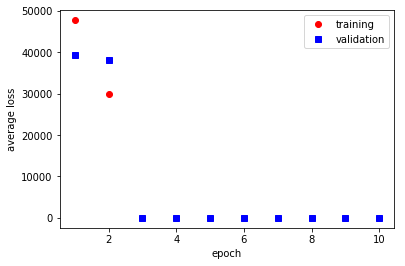

In [16]:
# Train the neural network.
learningRate = 1e-7
set_momentum = 0.8
decay = 1e-7

gc.collect()

network = SegNet(n_classes, pretrained=True)
#criterion = CrossEntropyLoss2d(size_average=False, ignore_index=ignore_label)

criterion = CrossEntropy2d(size_average=False)

optimizer = optim.SGD(network.parameters(), lr = learningRate, momentum = set_momentum, weight_decay = decay)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 2, use_gpu = True)

# Plot loss and accuracy.
ep = np.arange(1, 11, 1)
plt.plot(ep, loss_train, 'ro',ep, loss_validate, 'bs')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.legend(['training','validation'])
plt.show()

HBox(children=(IntProgress(value=0, description='Training epoch 0', max=298), HTML(value='')))

0/|/  0%|| 0/298 [00:01<?, ?it/s, loss=5.98e+04]
297/|/100%|| 297/298 [07:16<00:01,  1.47s/it, loss=1.49e+04]

HBox(children=(IntProgress(value=0, description='Validation epoch 0', max=50), HTML(value='')))

49/|/ 98%|| 49/50 [01:04<00:01,  1.31s/it, loss=6.76e+03]

HBox(children=(IntProgress(value=0, description='Training epoch 1', max=298), HTML(value='')))

297/|/100%|| 297/298 [07:14<00:01,  1.46s/it, loss=6.49e+03]

HBox(children=(IntProgress(value=0, description='Validation epoch 1', max=50), HTML(value='')))

49/|/ 98%|| 49/50 [01:04<00:01,  1.31s/it, loss=5.73e+03]

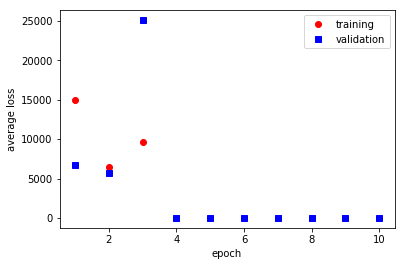

In [30]:
# Train another network
learningRate = 1e-6
set_momentum = 0.8
decay = 1e-6

gc.collect()

network2 = segnet2()
criterion = CrossEntropy2d(size_average=False)
optimizer = optim.SGD(network2.parameters(), lr = learningRate, momentum = set_momentum, weight_decay = decay)

# Train the previously defined model.
train_model(network2, criterion, optimizer, trainLoader, valLoader, n_epochs = 2, use_gpu = True)

# Plot loss and accuracy.
ep = np.arange(1, 11, 1)
plt.plot(ep, loss_train, 'ro',ep, loss_validate, 'bs')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.legend(['training','validation'])
plt.show()

In [39]:
learningRate = 1e-7
set_momentum = 0.8
decay = 1e-6

# For more training iterations.
train_model(network2, criterion, optimizer, trainLoader, valLoader, n_epochs = 2, use_gpu = True)

# Plot loss and accuracy.
ep = np.arange(1, 11, 1)
plt.plot(ep, loss_train, 'ro',ep, loss_validate, 'bs')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.legend(['training','validation'])
plt.show()

HBox(children=(IntProgress(value=0, description='Training epoch 0', max=298), HTML(value='')))


46/|/ 15%|| 46/298 [01:07<06:09,  1.47s/it, loss=5.92e+03]

KeyboardInterrupt: 

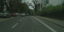

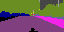

[[ 1  1 17 ...,  0  0  8]
 [ 7  1  0 ...,  1  0  0]
 [ 0 18  1 ...,  4 10 10]
 ..., 
 [ 7  1  7 ...,  3  1  0]
 [14  1  1 ..., 10  4  1]
 [ 6  0  1 ...,  1  1  1]]


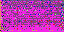

In [44]:
def pred_demo(network,image):
    network.eval()
    image = image.view(1,image.size(0),image.size(1), image.size(2))
    inputVar =  Variable(image,volatile=True).cuda()
    predictions = network(inputVar)
    #predictions = -F.log_softmax(predictions)
    #print(predictions)
    predictions = predictions.data.squeeze().max(0)[1].cpu().numpy()
    print(predictions)
    predictions = colorize_mask(predictions)
    lab_utils.show_image(predictions)
    

"""
testset = CityScapes(mode = 'test', root = 'dataset', transform = imgTransform,
                    target_transform = target_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = False, num_workers = 0)
"""

network = network.cuda()
#image1 = Image.open('data/valset/cat.41.jpg').convert('RGB')

img, mask = trainset[30]
lab_utils.show_image(restore_transform(img));
lab_utils.show_image(colorize_mask(np.array(lab_utils.tensor2pil(mask))));

pred_demo(network,img)

In [412]:
gc.collect()

0